In [9]:
#!/usr/bin/env python
"""
Run inference over a dataset using a saved tf model
"""
# import matplotlib
# matplotlib.use('agg')

import tensorflow as tf
import numpy as np
import argparse
import matplotlib.pyplot as plt


IMG_SIZE = 448
INT_IMG_SIZE = (5*IMG_SIZE, 3*IMG_SIZE)


def vectoriser(arr, level=0.01, latlon=True):
    """
    input: arr -> a square 2D binary mask array
    output: polys -> a list of vectorised polygons
    
    From https://gist.github.com/Lkruitwagen/26c6ba8cadbfd89ab42f36f6a3bbdd35
    """    
    from skimage import measure
    
    polys = []

    contours = measure.find_contours(arr, level)
    
    for c in contours:
        if latlon:
            c = np.stack([da.longitude[(np.round(c[:,1])).astype('int')], da.latitude[(np.round(c[:,0])).astype('int')]], 1)
        else:
            c.T[[0, 1]] = c.T[[1, 0]] # swap lons<->lats
        poly = geometry.Polygon(c) # pass into geometry
        polys.append(poly)
#     return geometry.MultiPolygon(polys)
    return geopandas.GeoDataFrame({"geometry": polys})


def split_array(arr, step_size=440):
    x_len, y_len = arr.shape[0:2]
    x_split_locs = range(step_size, x_len, step_size)
    y_split_locs = range(step_size, y_len, step_size)
    v_splits = np.array_split(arr, x_split_locs, axis=0)
    return sum((np.array_split(v_split, y_split_locs, axis=1) for v_split in v_splits), [])


def get_image(file):
    from PIL import ImageOps, Image

    im_data = Image.open(file)
    
    # Drop the alpha channel
    im_data = np.array(im_data)[:, :, 0:3]
    
    return im_data


def resize_arr(arr, target_size, bilinear=True):
    from PIL import Image
    
    resampler = Image.BILINEAR if bilinear else Image.NEAREST
    
    arr_im = Image.fromarray(arr)

    arr_im = arr_im.resize(target_size, resample=resampler)
    
    new_arr = np.array(arr_im)
    return new_arr


def combine_masks(masks):

    nested_masks = [np.split(m, 3) for m in np.split(masks[..., 0], 5, 0)]
    mask = np.squeeze(np.block(nested_masks))

    return mask


def get_ship_track_mask(f):
    data  = get_image(f)
    
    original_size = data.shape[1::-1] # The size is the inverse of the shape (minus the color channel)

    reshaped_data = resize_arr(data, INT_IMG_SIZE[::-1])
    
    split_data = split_array(reshaped_data / 255., IMG_SIZE)

    prediction = tf_predictor(data=tf.constant(split_data, dtype='float32'))

#     prediction = prediction['sigmoid'] > 0.5

    mask = combine_masks(prediction['sigmoid'])
    
    new_mask = resize_arr(mask, original_size)
    
    return data, new_mask



In [3]:
parser = argparse.ArgumentParser()

# parser.add_argument('model', help="The model directory to use")
# parser.add_argument('infiles', nargs='*')
# parser.add_argument('--infile', help="Input file", type=argparse.FileType('r'))
# parser.add_argument('--show', action='store_true')
# parser.add_argument('-o', '--outfile', help="Output name", default='mask')

# args = parser.parse_args()

args = {
    "model": "/home/jovyan/lustre_scratch/models/20210713_174611_new_resnet152_bce_jaccard_loss/model/2",
    "infiles": ["/lustre_scratch/duncanwp/combined_v3_typed_new_composite/myd2016311.1720D.png"],
}

model = tf.saved_model.load(args['model'])
tf_predictor = model.signatures["serving_default"]



2021-07-14 10:06:30.300739: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-14 10:06:30.462516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: Tesla V100-SXM2-32GB-LS computeCapability: 7.0
coreClock: 1.44GHz coreCount: 80 deviceMemorySize: 31.72GiB deviceMemoryBandwidth: 772.48GiB/s
2021-07-14 10:06:30.466452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:8a:00.0 name: Tesla V100-SXM2-32GB-LS computeCapability: 7.0
coreClock: 1.44GHz coreCount: 80 deviceMemorySize: 31.72GiB deviceMemoryBandwidth: 772.48GiB/s
2021-07-14 10:06:30.466490: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-14 10:06:30.472483: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcubl

ConcreteFunction signature_wrapper(*, data)
  Args:
    data: float32 Tensor, shape=(None, None, None, 3)
  Returns:
    {'sigmoid': <1>}
      <1>: float32 Tensor, shape=(None, None, None, 1)


(2030, 1354, 3)
True
(2030, 1354)


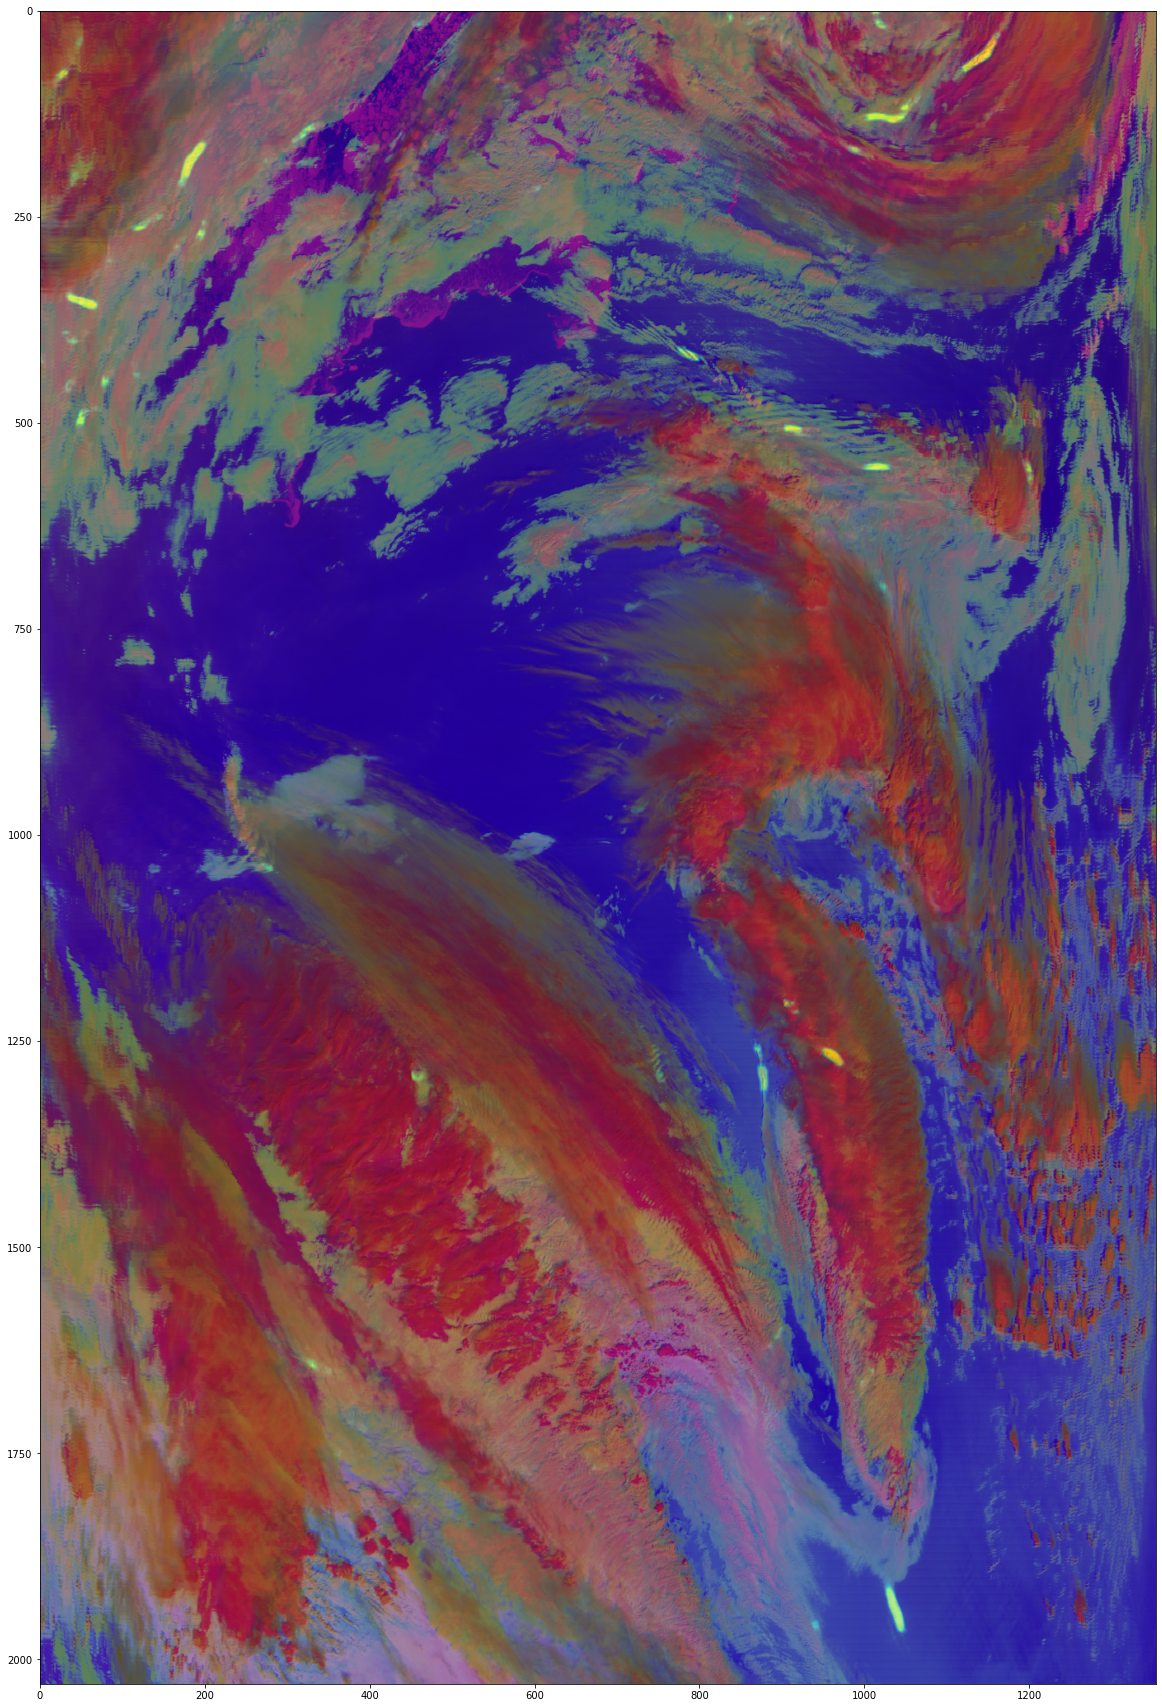

In [10]:

infiles = args['infiles']

for f in infiles:
    data, mask = get_ship_track_mask(f)

    print(data.shape)
    print(mask.any())
    print(mask.shape)
    if mask.any():
        fig, axs = plt.subplots(figsize=(20, 40))
        axs.imshow(data, vmin=0., vmax=1.)
        im=axs.imshow(mask, alpha=0.5, vmin=0, vmax=1)
#         plt.colorbar(im)
#         plt.savefig(f"{f[:-4]}_{args.outfile}.png")
        plt.show()
#         np.savez_compressed(f"{f[:-4]}_{args.outfile}.npz", mask=mask)
    else:
        print(f"No shiptracks found in {f}")

In [ ]:
(2030, 1354, 3)[1::-1]